In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt

DDIR = os.path.expanduser("~/data/common")
if not os.path.exists(DDIR):
    os.makedirs(DDIR)
mnist_transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = torchvision.datasets.MNIST(
    root=DDIR, train=True, download=True,
    transform=mnist_transform)
mnist_trainloader = torch.utils.data.DataLoader(
    mnist_trainset, batch_size=32,
    shuffle=True, num_workers=2
)
mnist_testset = torchvision.datasets.MNIST(
    root=DDIR, train=False, download=True,
    transform=mnist_transform)
mnist_testloader = torch.utils.data.DataLoader(
    mnist_testset, batch_size=32
)

#### Helper functions ####

def show(img):
    npimg = img.detach().numpy()
    npimg -= npimg.min()
    npimg /= npimg.max()
    if npimg.shape[0] in [3,4]:
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    else:
        plt.imshow(npimg.squeeze(), interpolation='nearest', cmap='gray')
        
def draw_balls(C, sample=None):
    plt.figure(1, figsize=(20,1))
    s = 1024
    for i, c_ in enumerate(C):
        plt.scatter(i+1, 1, s=s, c=c_)
    if sample is not None:
        plt.scatter(sample+1, 1, s=s*1.5, c='none', edgecolors=['k',])
    plt.xlim([0, len(C)+1])
    plt.ylim([0.9, 1.1])
    #axis('equal')
    plt.axis('off')
    plt.show()
    
def play_game(urn, seed=None):
    if seed is not None:
        rng = np.random.RandomState(seed)
    else:
        rng = np.random.RandomState()
        
    games = 0
    guesses = []
    while True:
        sample = rng.randint(len(urn))
        draw_balls(urn, sample)
        g = int(input("How many guesses: "))
        guesses.append(g)
        games += 1
        
        
        more = input("Play more? [y]|n")
        if more=='n' or more=='N':
            break
        
    avg_guesses = np.mean(guesses)    
    print ("Finished: {}, average questions".format(guesses, avg_guesses))
    return avg_guesses


# Where are we -- in the learning framework?


<img src="ref/learning.png" alt="LearningFramework" height="400" width="500">

The major players:
- data
- models (hypotheses)
- algorithm
- <span style="color:red;font-weight:bold"> selection criterion </span>

# Quantifying Information

A systematic way of "how much my model has told me about the answer?"

#### Good criteria

It is related to the form of the target of prediction and the model output.

- Relevant to the ultimate goal. 
- Differentiable 

# Entropy

The goal is to compare two systems. Let us first consider the information in ONE "system" -- probabilistic distribution. And by the way, derive an effeicient shceme of _asking questions_, i.e. the _motivation_ behind most decision tree algorithms. 

To take the notion of _information_ specifically, 

- the minimum average code length to communicate an element drawn from the system.
    - the codec-scheme must be determined BEFOREhand

- how many ways you can arrange the stuff in a system -- the number of status of a system

## Cost of A Guessing Game
Let us start from a guessing GAME to understand the concept of "measuring the information": 
```
Consider Bob has an urn containing colour balls.  Alice know the contents in the urn.  Now Bob draw one ball from the urn, Alice wants to know the colour of the ball. Bob can answer "yes/no" questions, but charge one dollar per question. 
```

The goal is to design an asking scheme for Alice, so avargely she pays the lest.

### GAME-1
Try water ...

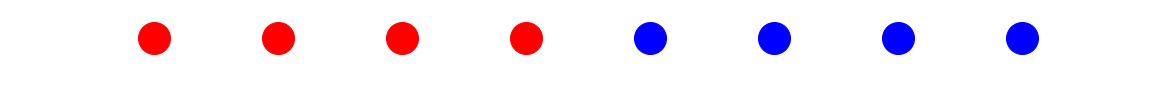

In [6]:
urn = ['r', 'r', 'r', 'r', 'b', 'b', 'b', 'b']
draw_balls(urn)

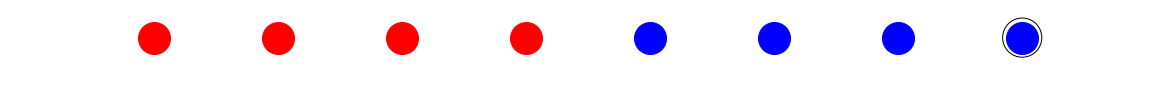

How many guesses: 1
Play more? [y]|ny


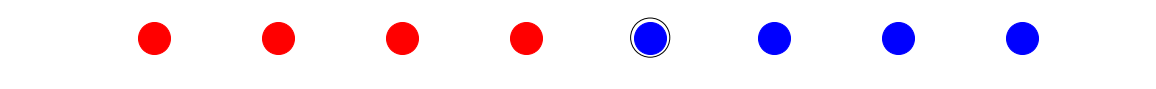

How many guesses: 1
Play more? [y]|ny


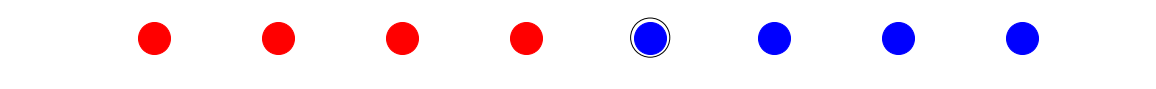

How many guesses: 1
Play more? [y]|ny


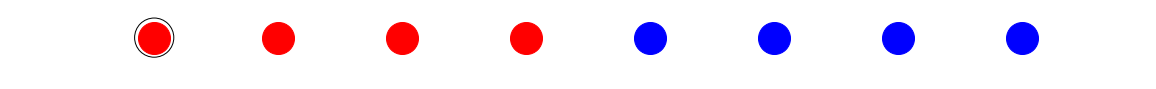

How many guesses: 1
Play more? [y]|nn
Finished: [1, 1, 1, 1], average questions


1.0

In [7]:
play_game(urn)

# GAME-2
More elements.

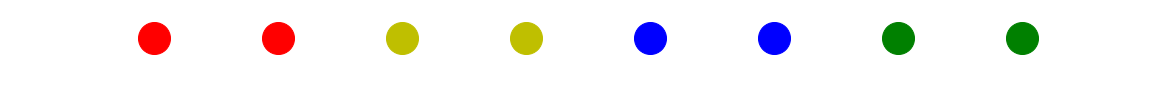

In [5]:
# Game 2
urn = ['r', 'r', 'y', 'y', 'b', 'b', 'g', 'g']
draw_balls(urn)

In [ ]:
# 1. ask is the ball yellow or red?
# 2.1 if 'y': ask is the ball red?
# 2.2 if 'n': ask is the ball blue?
play_game(urn)

### GAME-3
Maybe we can allocate codes smartly.

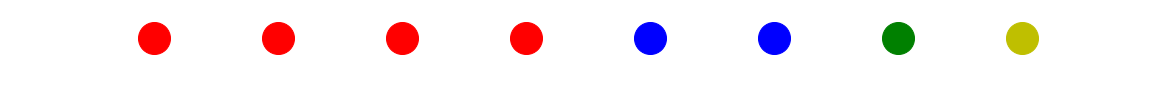

In [8]:
# Game 3
urn = ['r', 'r', 'r', 'r', 'b', 'b', 'g', 'y']
draw_balls(urn)


In [ ]:
play_game(urn)

# GAME-4
It all about UNcertainty.

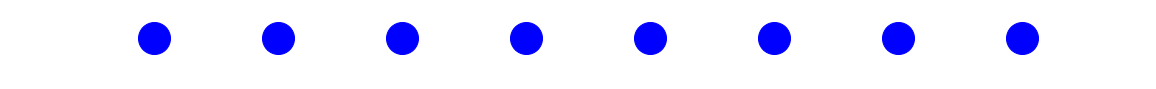

In [9]:
urn = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
draw_balls(urn)

In [ ]:
play_game(urn)

## Scheme
Design principles:

- earlier questions should identify frequent elements; rare elements are concerned later

- Code length: $\log_2 \frac{1}{p_i}$ for event with probability $p_i$

# Entropy

Definition w.r.t. minimum coding length:
 $$ \sum_i p_i \log_2 \frac{1}{p_i} $$

- Sum over all elements
- why $p_i$
- motivation of $\log (1/p)$
    - when $p$ is large
    - when $p$ is small
- why base-2

## Couting System States

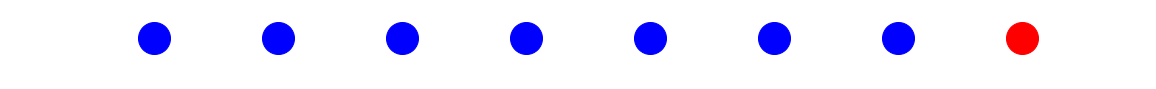

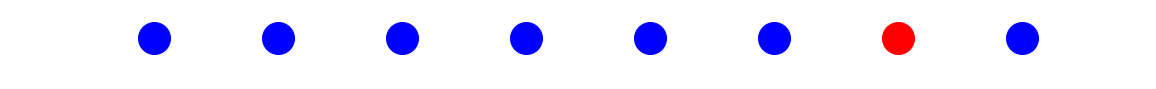

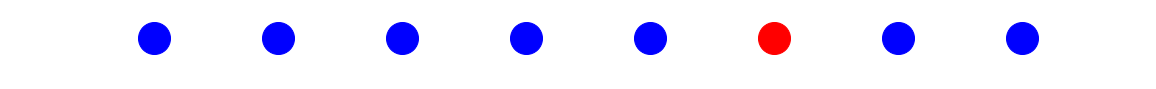

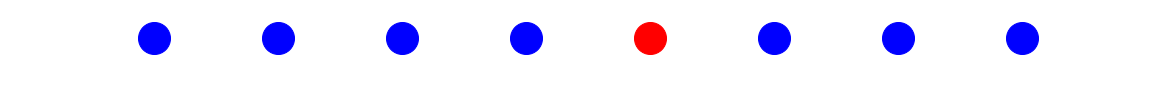

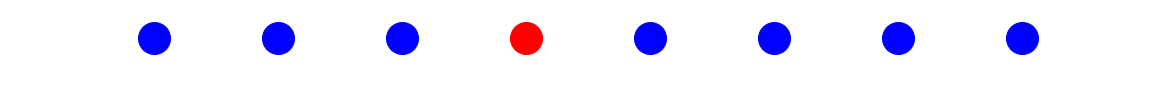

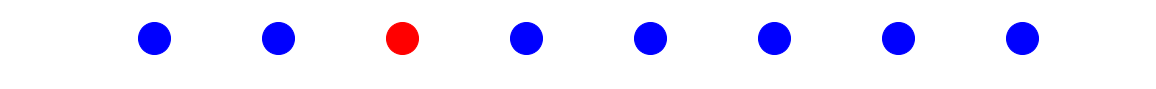

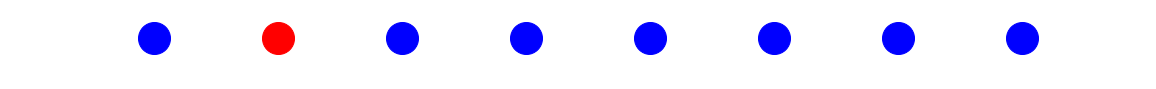

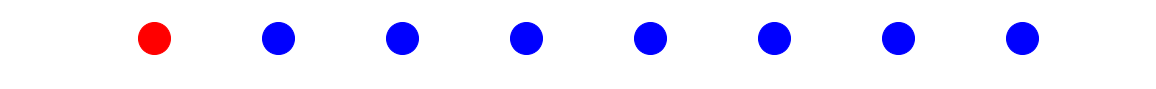

In [10]:
urns = [['b', 'b', 'b', 'b', 'b', 'b', 'b', 'r'],
        ['b', 'b', 'b', 'b', 'b', 'b', 'r', 'b'],
        ['b', 'b', 'b', 'b', 'b', 'r', 'b', 'b'],
        ['b', 'b', 'b', 'b', 'r', 'b', 'b', 'b'],
        ['b', 'b', 'b', 'r', 'b', 'b', 'b', 'b'],
        ['b', 'b', 'r', 'b', 'b', 'b', 'b', 'b'],
        ['b', 'r', 'b', 'b', 'b', 'b', 'b', 'b'],
        ['r', 'b', 'b', 'b', 'b', 'b', 'b', 'b']]

for u_ in urns:
    draw_balls(u_)


There are $\left(\begin{array}{c}
8\\
1
\end{array}\right)=8$ _different_ ways of arranging the 8 balls.

__Q__: How many different ways to arrange the balls if there are 2 red balls and 6 blue ones?

There are $$\left(\begin{array}{c}
8\\
2
\end{array}\right)=\frac{8!}{2!\cdot 6!}$$ _different_ ways of arranging the 8 balls.

In [11]:
print(8*7*6*5*4*3*2*1/((2*1)*(6*5*4*3*2*1)))

28.0


Why more than the 1-red-7-blue case?

## Counting possible states of $N$-element System

Ways to organise $N$ elements, and there are $p_1 \cdot N$ elements of the first kinds, $p_2 \cdot N$ elements of the second kinds, ... (totally $k$ kinds)

$$
 \frac{N!}{(p_{1}N)!(p_{2}N)!\dots(p_{k}N)!}\\
\simeq \frac{N^{N}}{(p_{1}N)^{p_{1}N}(p_{2}N)^{p_{2}N}\dots(p_{k}N)^{p_{k}N}}
$$

The approximation is according to [Stirling's approximation][1], where 

> $\log (N!) \simeq N \log N - N + O(N) $

[1]:https://en.wikipedia.org/wiki/Stirling%27s_approximation


The system entropy is 
$$ S = - \sum_i^k p_i \log_2 {p_i} $$
then the number of status is $$2^{N\cdot S}$$

That is, one sample from the system carries the information: 
> Hey, this is the particular one in $2^{NS}$.

Removing the factor of $N$ (which we always let grow to infinity in this kind of analysis), the entropy $S$ is the average bits of information each sample carries.

# Evaluating Model

Consider that the ground-truth answer of a classification problem is 2 in $[0, 1, 2]$, and your model's output is $(0.1, 0.1, 0.8)$ If someone make a coding scheme according to your model's prediction about the labels:

i.e. transmitting 
- event $Y=0$ with code length $- \log_2 0.1$, 
- and $Y=1$ with code length $- \log_2 0.1$, 
- and $Y=2$ with code length $- \log_2 0.8$. 

If the $Y$-variable associated with the data sample $X$ is truly $[0.1, 0.1, 0.8]$ as predicted, the coding scheme is optimal.

__Q__: What is the optimal expected coding length?

However, the actual "probability" is 
- $Pr$(The sample belongs to Class-0) $=0$
- $Pr$(The sample belongs to Class-1) $=0$
- $Pr$(The sample belongs to Class-2) $=1.0$
The actual coding cost would be $$0 + 0  - \log_2 0.8 \simeq 0.322$$

- This is of course shorter than the expected code length of given the prediction by the model. However, the "true" optimal coding should be $0+0+log_2 1.0 = 0$, i.e. if the prediction is 100% correct and confident, there would not be any need of extra coding at all. 

So we introduce the concept of cross-entropy. The intution is that 
> I have my version of the probabiliy of events and made coding scheme accordingly. However, the actual distribution is otherwise. 

Note, the difference between the optimal coding scheme is called KL-Divergence. [Here](http://octavia.zoology.washington.edu/teaching/429/lecturenotes/lecture3.pdf) is a comprehensive introduction.


## Decision Tress -- A Revisit

Below is a pseudo-code implementation of ID3 algorithm

```
# 31005 Students can use for A2

def id3(examples, target, attrs):
  create root node for tree
  
  if examples all +ve, 
    return root with label=+ 
  
  if examples all -ve, 
    return root with label=- 
  
  if attrs is empty
    return root w/ label=most common value of target in examples 
  else 
    A ← attribute from attrs that best splits examples 

  root ← A
  for each possible value vi in A
    add a new branch below root corresp. to the test A = vi 
    examples_vi ← the subset of examples with A = vi
  
  if examples_vi is empty
    add a leaf node below branch w/ label = most common value of target from examples
  else 
    below the branch add the subtree given by id3(examples_vi, target, attrs - { A })
```

Decision trees "would like to" lead you (using the branch at each node) to a sub-population of the data that is purer than the parent node-population.

The basic ideas behind decision tree building and of minimising cross-entropy are similar:

__Let what a model says about an $X$ tells most about the corresponding $Y$__

# Q/A

__LAB_Q__
Compute the entropy of 
- 0.125 * np.log2(0.125) - 0.675 * np.log2(0.675)

__LAB_Q__
How about the number of combinations of 6 blue balls, 1 red ball and 1 yellow ball? 

__LAB_Q__:
Coding: given $N$ and $p<N$, compute the LOG-value of
$$
  \frac{N!}{(pN)!((1-p)N)!}\\
\simeq  \frac{N^{N}}{(pN)^{pN}((1-)N)^{(1-p)N}}
$$

Try different ($N$, $p$) combinations, and show they are relatively close when $N$ is large.

In [ ]:
import math
import torch
f = lambda k: (torch.arange(k)+1).log_().sum().item()
g = lambda k: math.log(k)*k
h = lambda n, m, f_: f_(n) - f_(m) - f_(n-m)
print(h(10000000, 60000, f), h(10000000, 60000, g))

__LAB_Q__:

Consider a classification task: e.g. our old friend, the hand-written digit classifier. Let's check the model and its output on our images.

Define a hand-written digit classifier, with 10 outputs corresponding to the digits. Try
- Negative log likelihood loss
- MSE loss
- L1 loss
Discuss your findings.

In [ ]:
class HandwrittenDigitNet(nn.Module):
    def __init__(self):
        super(HandwrittenDigitNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=64, 
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=3)
        self.linear = nn.Linear(3200, 10)
        
    def forward(self, x):
        """
        :param x: a batch of images
        """
        h = self.conv1(x)
        h = F.leaky_relu(h, 0.2, inplace=True)
        h = F.max_pool2d(h, 2)
        h = self.conv2(h)
        h = F.leaky_relu(h, 0.2, inplace=True)
        h = F.max_pool2d(h, 2)
        h = self.linear(h.view(h.shape[0], 3200))
        h = F.log_softmax(h, dim=1)
        return h

In [ ]:
mnist_net = HandwrittenDigitNet()
for X, y in mnist_trainloader:
    h = mnist_net(X)
    break
print()

__Q__: What is the output for an input sample in this example?

__Q__: what is the desirable output of a particular sample?